https://github.com/RadionBik/Statistical-estimator-of-network-traffic

## Original traffic characterization

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
#sys.path.append("..")
from stat_estimator import *
from packet_transceiver import *
from traffic_helpers import *
from hmm_helpers import *
from gmm_helpers import *

from plot_helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Extracting flow features from traffic_dumps/skypeLANhome.pcap...
Extracting flow identifiers from traffic_dumps/skypeLANhome.pcap...
Found the following flows with # of packets > 100:
UDP 192.168.0.102:18826 192.168.0.105:26454 pkt number from: 3623
UDP 192.168.0.102:18826 192.168.0.105:26454 pkt number to: 3700
Finished extracting packet properties
Preparing histograms for the traffic...


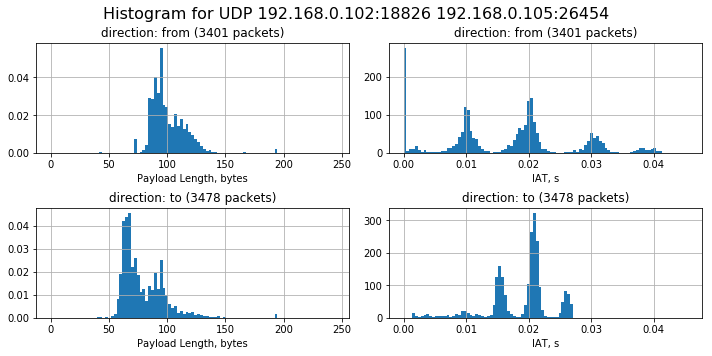

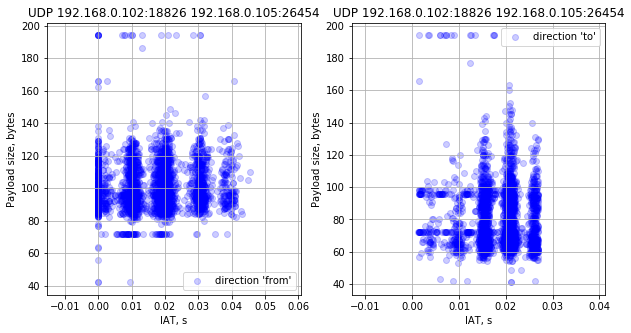

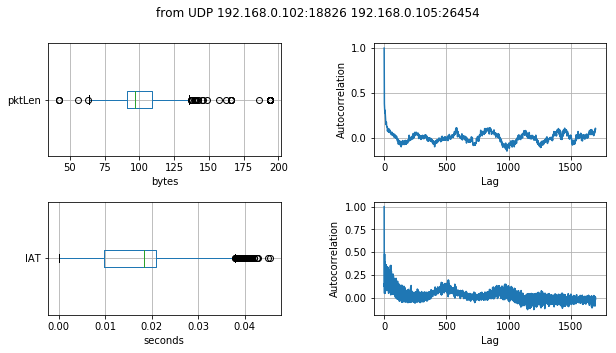

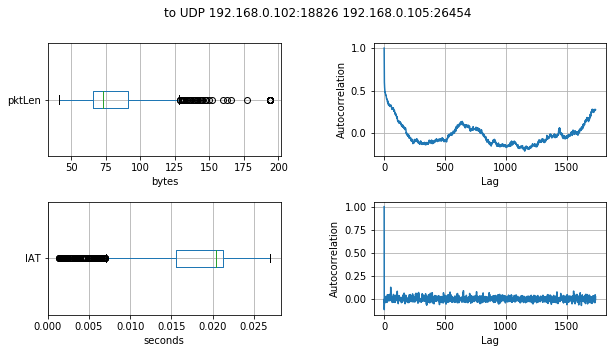

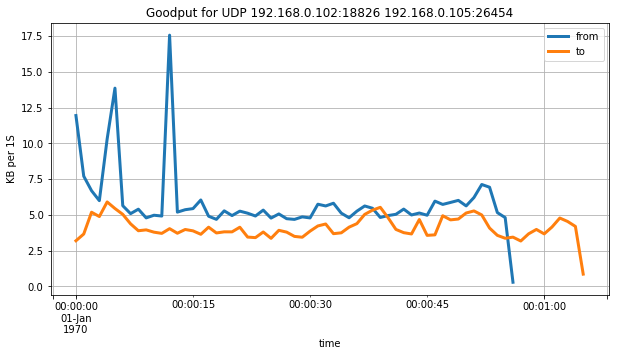

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]

pcapfile = 'traffic_dumps/skypeLANhome.pcap'
traffic_dfs = getTrafficFeatures(pcapfile,'all','flow',(3,97),100)[0]
norm_traffic, scalers = normalize_dfs(traffic_dfs)
plot_hist(traffic_dfs, logScale=0, saveToFile='orig')
plot_2D_hist(traffic_dfs, logScale=0, saveToFile='orig')
plot_stat_properties(traffic_dfs, saveToFile='orig')
goodput_orig = get_goodput(traffic_dfs, '1S', saveToFile='orig')

## Train HMM, GMM and GMM-HMM models

1. Hidden Markov Model, the number of componenets is adjusted manually. The strategy is to use the highest possible number of componets, however, in case of issues with training, it must be decreased.
2. Gaussian Mixture Model with Dirichlet distributed weights. The principle applies as above. See stat_estimator.py for example of code adjusting componet number by Bayessian Information Criterion.
3. GMM-HMM. That is a HMM, where each component is modelled as a GMM. If transitions between components are of importance, the general approach is to set more HMM states with fewer GMM components.

In [41]:
test_cases = ['HMM','GMM','HMM-GMM']
#test_cases = ['GMM']
comp_numb = 10
models = {}
for test_case in test_cases:
    print(f'-------- Started fitting {test_case} ---------')
    if test_case=='HMM':
        models.update({test_case : get_hmm_gaussian_models(norm_traffic, comp_numb)})
    elif test_case=='GMM':
        models.update({test_case : get_gmm(norm_traffic, comp_numb)})
    elif test_case=='HMM-GMM':
        models.update({test_case : get_hmm_gmm(norm_traffic, 5, 2)})
        

-------- Started fitting HMM ---------
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "from"
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "to"
-------- Started fitting GMM ---------
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "from"
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "to"
-------- Started fitting HMM-GMM ---------
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "from"
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "to"


## Characterize generated traffic

Preparing histograms for the traffic...
Preparing histograms for the traffic...
Preparing histograms for the traffic...


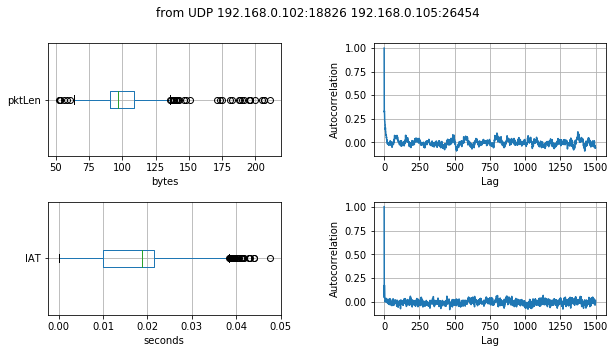

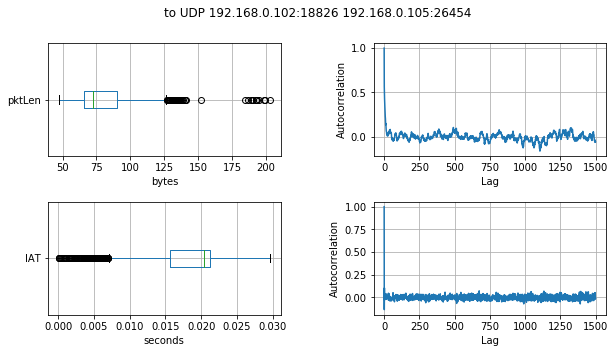

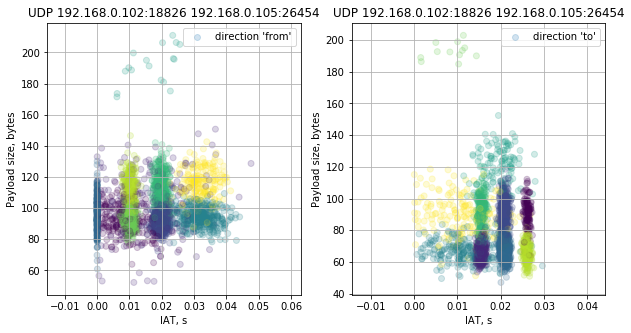

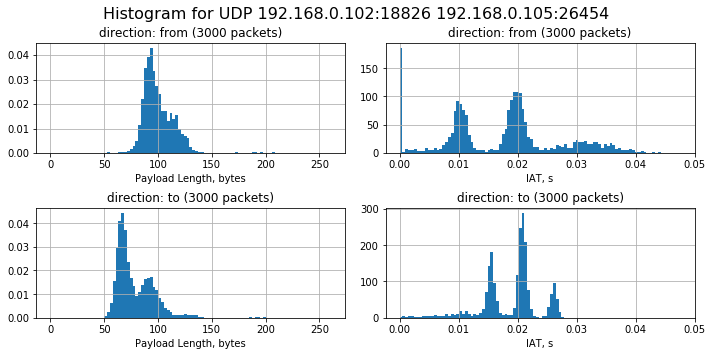

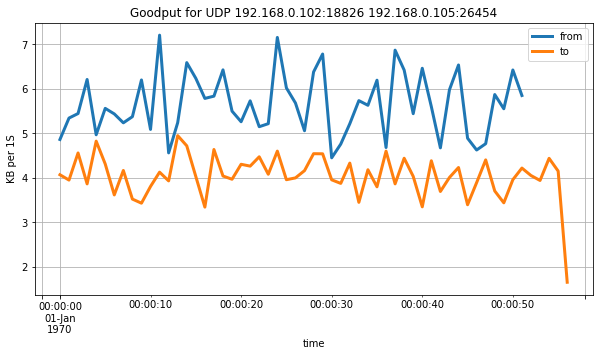

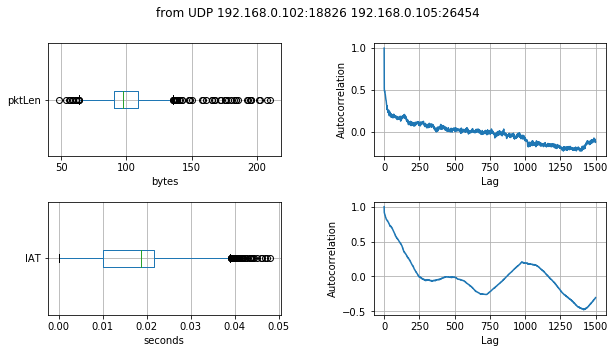

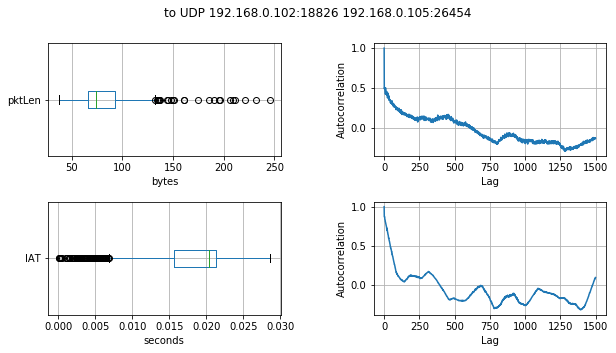

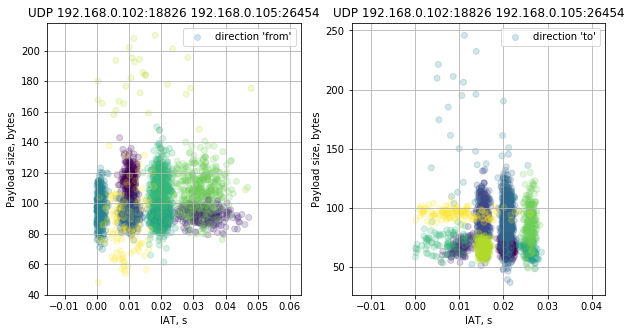

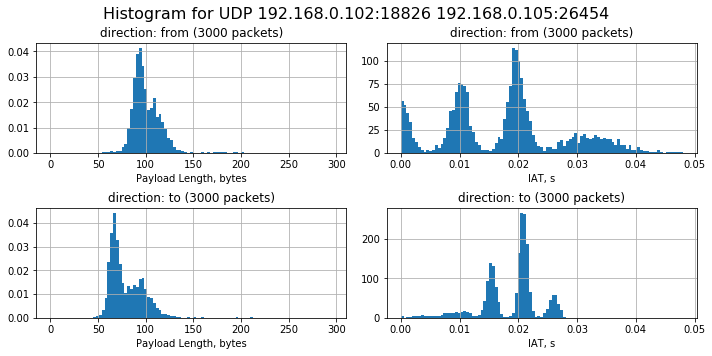

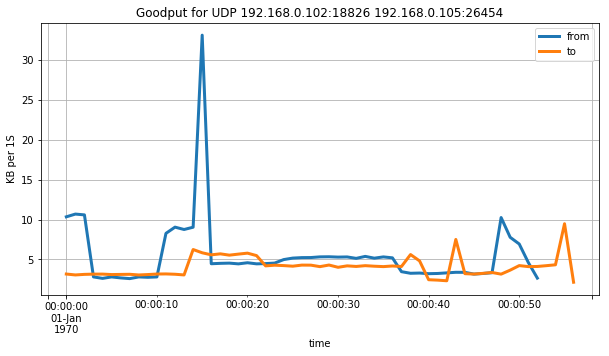

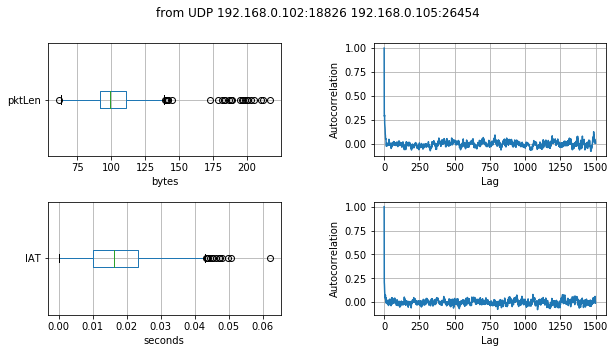

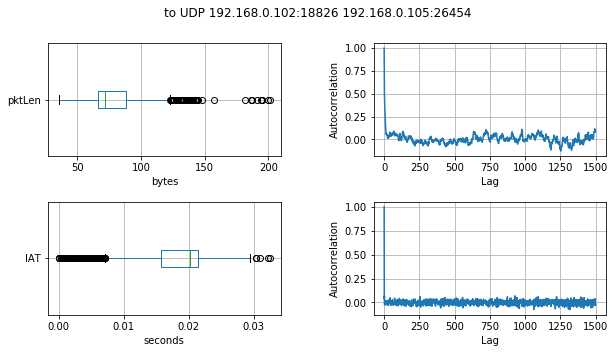

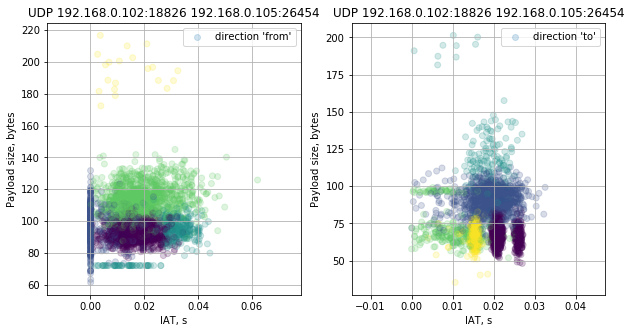

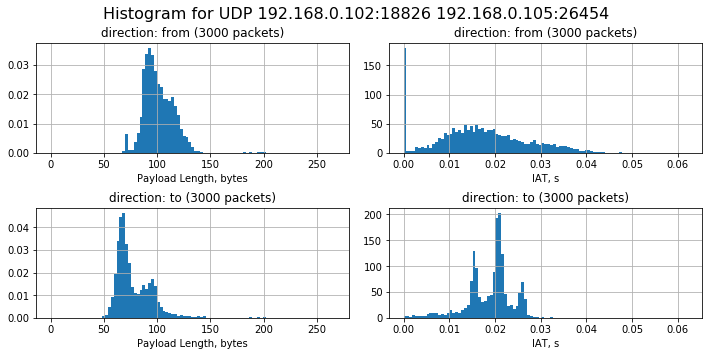

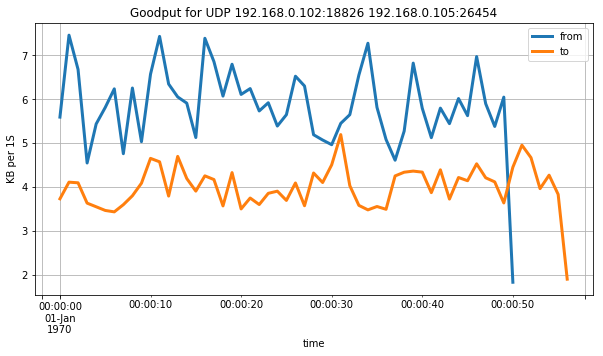

In [42]:
gener_dfs = {}
for model in models:
    #if model!='HMM':
    #    continue
    gener_df, states = gener_samples(models[model], scalers, 3000)
    plot_stat_properties(gener_df, saveToFile=model)
    plot_2D_hist(gener_df,states=states, saveToFile=model)
    plot_hist(gener_df, logScale = False, saveToFile=model)
    get_goodput(gener_df, saveToFile=model)
    gener_dfs.update({model: gener_df})

## Compare original and generated traffic statistics

In [43]:
from stat_tests import *
for model in gener_dfs:
    print('Comparison of original distributions with {}:'.format(model))
    kl_divergences = get_KL_divergence(traffic_dfs, gener_dfs[model])
    ks_tests = get_ks_2sample_test(traffic_dfs, gener_dfs[model])
    qq_r = get_qq_r_comparison(traffic_dfs, gener_dfs[model])
    #for device, direction, parameter, ks in iterate_traffic_3_layers(ks_tests):
    #    print(ks)

Comparison of original distributions with HMM:
Kulback-Leibler divergence:
from, IAT    	0.0248
from, pktLen 	0.0222
to  , IAT    	0.0079
to  , pktLen 	0.0191
Kolmogorov-Smirnov 2-sample test:
           statistic   p-value
from ,IAT      0.068  0.000002
              statistic   p-value
from ,pktLen   0.042333  0.008939
         statistic   p-value
to ,IAT   0.035667  0.042962
            statistic   p-value
to ,pktLen      0.062  0.000018
Correlation of percentiles:
from:
IAT       0.988082
pktLen    0.995391
dtype: float64
to:
IAT       0.993986
pktLen    0.998110
dtype: float64


Comparison of original distributions with GMM:
Kulback-Leibler divergence:
from, IAT    	0.0187
from, pktLen 	0.0168
to  , IAT    	0.0050
to  , pktLen 	0.0152
Kolmogorov-Smirnov 2-sample test:
           statistic       p-value
from ,IAT   0.119667  3.350073e-19
              statistic   p-value
from ,pktLen   0.031667  0.096867
         statistic   p-value
to ,IAT   0.030333  0.124312
            statisti

## Conclusions

It appears that all models can model histogram properties well, given sufficient number of components. However, HMM and HMM-GMM can reproduce time-series better than GMM due to  ability to handle transitions between components. Moreover, HMM imitates original traffic closer than HMM-GMM with the same number of hidden variables.  

## TODO

1. Stat. analysis of non-Gaussian processes (time-series)
2. NN as a Gaussian Mixture
3. Transition from HMM to RNN  (обосновать архитектуру сети)
4. SDN applications and OpenFlow